# Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")

%pylab inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import seaborn as sns

import findspark 
findspark.init() # Used to properly connect to Spark Master
import pyspark   # Only run after findspark.init()

from pyspark.sql import SQLContext
from pyspark import SparkContext, SparkConf

conf = SparkConf().set("spark.driver.maxResultSize", "20g") 

sc = SparkContext(appName="ALSModel", sparkHome="/usr/local/spark", conf=conf)    
sqlContext = SQLContext(sc)

from model.als_trainer import ALSTrainer
from pyspark.ml.recommendation import ALSModel

from utils.evaluate import spark_filepath_to_pandas
from utils.evaluate import evaluate

Populating the interactive namespace from numpy and matplotlib


## Finding Best ALS Parameters

 First we import the data to a Spark dataframe. We are not using the `TimeStamp` column in the `item_history` table, so the first job is to group the rows by (`user_id`, `item_id`) and sum the `frequencies`.

In [2]:
schema = StructType([
  StructField("user_id", IntegerType()), StructField("item_id", StringType()),
  StructField("latest_timestamp", IntegerType()), StructField("frequency", IntegerType()),
])
item_hist    = sqlContext.read.csv("data/item_history.tsv",sep="\t", header=True, schema=schema)

# Split item history in train, test and set validation aside for later
ihist_train_test, ihist_val = item_hist.randomSplit([0.9, 0.1 ], seed=42)

def get_key_value(p):
  # for grouping as key value
  return (int(p[0]),int(p[1].replace("I",""))), float(p[3])
# Group the user_ids summing the frequency column.
frequencyRDD = ihist_train_test.rdd.map(get_key_value).reduceByKey(lambda x: sum(list(x)) )
frequencyRDD = frequencyRDD.map(lambda x: Row(user_id=int(x[0][0]),item_id=int(x[0][1]),frequency=float(x[1])) )

frequencies = sqlContext.createDataFrame(frequencyRDD)

We will do cross-validation, spliting the data in ten groups, training in 9/10 of the data and validating on the remaining 1/10. We do that for all the ten small pieces and average the `root square mean error` for the ALS method. We will join this with a gridsearch for best parameters for the model. 
The parameters we are looking for are `maxIteration`, `regParam` and `rank`.

In [4]:
from pyspark.ml.evaluation import RegressionEvaluator

def kfoldALS(data, k, maxIter, regParam, rank, metricName='rmse'):
    # Modified from https://dataplatform.cloud.ibm.com/exchange/public/entry/view/99b857815e69353c04d95daefb3b91fa
    evaluations = []
    weights = [1.0] * k
    splits = data.randomSplit(weights)
    for i in range(0, k):  
        testingSet = splits[i]
        trainingSet = sqlContext.createDataFrame(sc.emptyRDD(), data.schema)
        for j in range(0, k):
            if i == j:
                continue
            else:
                trainingSet = trainingSet.union(splits[j])
        als = ALSTrainer(maxIter, regParam, rank=rank)
        als.fit(trainingSet)
        evaluation = als.evaluate(testingSet)
        #print('Loop {}: {} = {:.4f}'.format(i + 1, metricName, evaluation))
        evaluations.append(evaluation)
    return sum(evaluations) / float(len(evaluations))

#kfoldALS(frequencies, 3)

In [5]:
maxIters  = [10,15,20]
regParams = [0.01,0.1,0.3,1]
ranks     = [5,15,25]

RMSEs = []
for maxIt in maxIters:
  for regParam in regParams:
    for r in ranks:
      print(f"{maxIt}  {regParam}  {r}  :", end="\r")
      rmse = kfoldALS(frequencies, 10, maxIt, regParam, r)
      RMSEs.append( (maxIt, regParam, r, rmse ) )
      print(f"{maxIt}  {regParam}  {r}  : {rmse:.4f}", end="\r")

In [34]:
df = pd.DataFrame(RMSEs, columns=["maxIter", "regParam", "rank", "rmse"])
df.sort_values("rmse", inplace=True)

Text(0.5, 0, 'RSME')

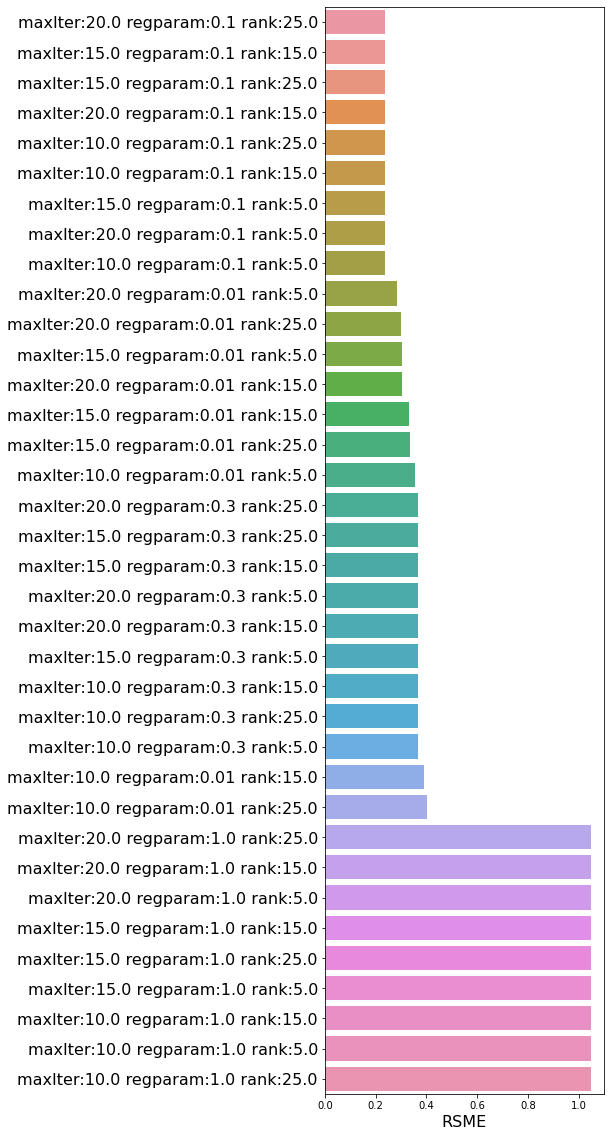

In [38]:
# We plot the final result as a vertical barplot
plt.figure(figsize=(5,20))
ax = sns.barplot(df.rmse, 
           df.apply(lambda r:f"maxIter:{r.maxIter} regparam:{r.regParam} rank:{r['rank']}", axis=1), 
           orient="horizontal"
           )
ax.tick_params(axis='y', which='major', labelsize=16)
ax.set_xlabel("RSME",fontsize=16)

## ALS Training

In [3]:
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType
schema = StructType([
      StructField("user_id", IntegerType()), 
      StructField("item_id", IntegerType()), 
      StructField("frequency", FloatType()),
    ])

frequencies = sqlContext.read.csv("data/train_frequencies.tsv",sep="\t", header=True, schema=schema).repartition(200)
target_users  = sqlContext.read.csv("data/target_users.tsv",sep="\t", header=True)
user_master  = sqlContext.read.csv("data/user_master.tsv",sep="\t", header=True)

In [28]:
maxIter = 20
regParam = 0.1
rank = 200

als = ALSTrainer(maxIter=maxIter, regParam=regParam, rank=rank)

In [29]:
train = frequencies.join(target_users, ["user_id"], how="inner").repartition(200)

In [32]:
als.fit(frequencies)
print("Done Fitting")

Done Fitting


In [ ]:
# uncomment this cell to save a trained model
#als.model.save(f"models/asl_{maxIter}_{str(regParam).replace('.','')}_{rank}.pkl")
#print("Done saving model")

In [ ]:
# uncomment this cell to load a pre-trained model
# m = ALSModel.load(f"models/asl_{maxIter}_{str(regParam).replace('.','')}_{rank}.pkl")
# als.model = m

In [43]:
usersRec = als.model.recommendForUserSubset(target_users.limit(13000).join(small,["user_id"],how="inner"), numItems=72)
print("done recommending")

done recommending


In [44]:
# Write the results to a file so the evaluation function can read.
als.write_recommomendation_to_csv(usersRec, 
                                  f"data/spark_asl_{maxIter}_{str(regParam).replace('.','')}_{rank}_target_users.tsv")

In [45]:
filepath = f"data/spark_asl_{maxIter}_{str(regParam).replace('.','')}_{rank}_target_users.tsv"

nDCGs, entropy, globalVar = evaluate(filepath,spark_file=True, spark_SQLContext=sqlContext)
metrics = pd.DataFrame(nDCGs, columns=["user_id", "nDCGs"])
print(f"nDCG avg:{metrics.nDCGs.mean():.4}")

8,000 / 8,338 (95.95)%
Stoping Writer
Entropy: 10.646034437494771
nDCG avg:0.01028


# Plots with Various Rank sizes

Next we plot the distribution of the nDCG with various rank sizes. AS the rank increased the performance also increased, suggesting that ranks like 5 or even 50 are too low for the complexity of the problem.

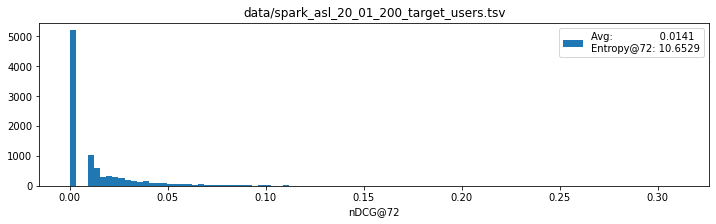

In [41]:
# Small = 1/100th of the whole data 
avg = metrics.nDCGs.mean()
_ = plt.figure(figsize=(12,3))
_ = plt.hist(metrics.nDCGs, bins=100, label=f"Avg:{avg:>21.4f}\nEntropy@72: {entropy:.4f}")
plt.title(f"{filepath}")
plt.xlabel("nDCG@72")
_ = plt.legend()

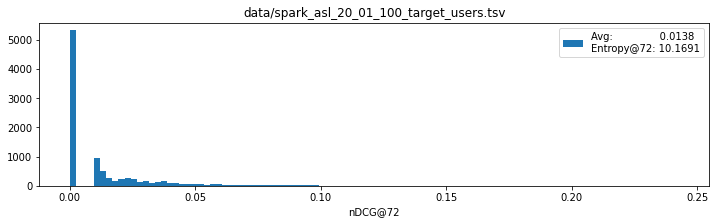

In [25]:
# Small = 1/100th of the whole data 
avg = metrics.nDCGs.mean()
_ = plt.figure(figsize=(12,3))
_ = plt.hist(metrics.nDCGs, bins=100, label=f"Avg:{avg:>21.4f}\nEntropy@72: {entropy:.4f}")
plt.title(f"{filepath}")
plt.xlabel("nDCG@72")
_ = plt.legend()

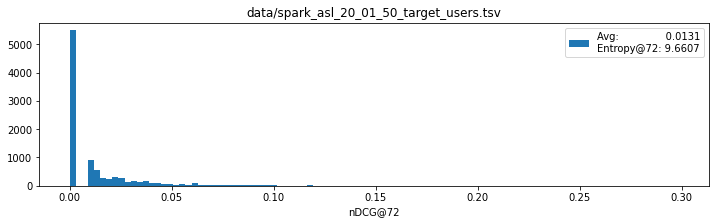

In [14]:
# Small = 1/100th of the whole data
avg = metrics.nDCGs.mean()
_ = plt.figure(figsize=(12,3))
_ = plt.hist(metrics.nDCGs, bins=100, label=f"Avg:{avg:>21.4f}\nEntropy@72: {entropy:.4f}")
plt.title(f"{filepath}")
plt.xlabel("nDCG@72")
_ = plt.legend()

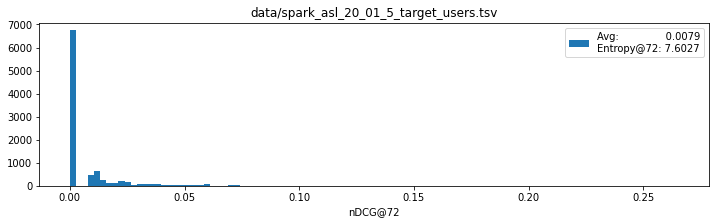

In [54]:
# Small = 1/100th of the whole data
avg = metrics.nDCGs.mean()
_ = plt.figure(figsize=(12,3))
_ = plt.hist(metrics.nDCGs, bins=100, label=f"Avg:{avg:>21.4f}\nEntropy@72: {entropy:.4f}")
plt.title(f"{filepath}")
plt.xlabel("nDCG@72")
_ = plt.legend()